# DC2 Image Analysis, Crab, Data Reduction

updated on 2023-12-01 (the commit b55ffd07153ce28296837cd6bfd37a88540d33d4)

This notebook focuses on how to produce the binned datasets with the spacecraft attitude (scatt) binning method for DC2.
Using the Crab 3month simulation data created for DC2, an example of the image analysis will be presented.
After running through this notebook, you can go to the next notebook, namely Crab-DC2-ScAtt-ImageDeconvolution.ipynb.

If you want to know about the other analysis, e.g., the spectral analysis, you can see the notebooks in docs/tutorials/spectral_fits.

In [3]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from tqdm.autonotebook import tqdm

# 0. Prepare the data
Before running the cells, please download the files needed for this notebook. You can get them from wasabi. 

Actually, the data reduction is not optimized and takes hours depending on your environments. So I skip this process.
Please download the following data files and then run the following cells.

From wasabi
- cosi-pipeline-public/COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5 (please unzip it)
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Sources/crab_3months_unbinned_data.fits.gz
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori

From docs/tutorials/image_deconvolution/Crab
- inputs_Crab_DC2.yaml

You can download the data and detector response from wasabi. You can skip this cell if you already have downloaded the files.
Note that the response is not public yet (2023-11-21).

In [ ]:
import os

header = "AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object"

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip --endpoint-url=https://s3.us-west-1.wasabisys.com SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/crab_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com crab_3months_unbinned_data.fits.gz")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com albedo_photons_3months_unbinned_data.fits.gz")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori --endpoint-url=https://s3.us-west-1.wasabisys.com 20280301_3_month.ori")

## Load the response and orientation files

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [4]:
path_data = "path/to/data/"

In [5]:
%%time

ori_filepath = path_data + "Data/Orientation/20280301_3_month.ori"
ori = SpacecraftFile.parse_from_file(ori_filepath)

CPU times: user 16 s, sys: 1.23 s, total: 17.2 s
Wall time: 16.9 s


In [6]:
full_detector_response_filename = path_data + "Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5"
full_detector_response = FullDetectorResponse.open(full_detector_response_filename)

nside = full_detector_response.nside
npix = hp.nside2npix(nside)

nside, npix

(8, 768)

In [7]:
full_detector_response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/DC2/prework/data/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 768
    NSIDE: 8
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 36
    EDGES: [0.0 deg, 5.0 deg, 10.0 deg, 15.0 deg, 

# 1. analyze the orientation file

Here the orientation file is analyzed to define the indices of the spacecraft attitude binning.

In [7]:
%%time

exposure_table = SpacecraftAttitudeExposureTable.from_orientation(ori, nside = nside, start = None, stop = None)
exposure_table

angular resolution:  7.329037678543799 deg.



WARNING ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"



duration:  92.36059027777777 d



WARNING ErfaWarning: ERFA function "utctai" yielded 7979955 of "dubious year (Note 3)"



  0%|          | 0/7979955 [00:00<?, ?it/s]

CPU times: user 30.9 s, sys: 1.65 s, total: 32.6 s
Wall time: 32.5 s


,scatt_binning_index,healpix_index,zpointing,xpointing,zpointing_averaged,xpointing_averaged,delta_time,exposure,num_pointings,bkg_group
0,0,"(532, 13)","[[44.62664815323754, -21.585226694584346], [44...","[[44.62664815323755, 68.41477330541565], [44.6...","[44.77592919492308, -21.83137450725276]","[44.79590102793104, 68.17007080261746]","[0.9999999999969589, 1.0000000000065512, 0.999...",71072.0,71072,0
1,1,"(532, 26)","[[45.66020516346508, -23.269427365755966], [45...","[[45.6602051634651, 66.73057263424403], [45.69...","[45.955010022713545, -23.741156770888438]","[45.95764244902919, 66.25906763976249]","[1.0000000000065512, 0.9999999999969589, 0.999...",26359.0,26359,0
2,2,"(532, 42)","[[46.29919922293719, -24.286823740507035], [46...","[[46.29919922293719, 65.71317625949297], [46.3...","[47.169799754806256, -25.642813300423782]","[47.188380045186555, 64.35902575261872]","[0.9999999999969589, 0.9999999999969589, 1.000...",71137.0,71137,0
3,3,"(564, 42)","[[48.1115581160702, -27.07000329743496], [48.1...","[[48.111558116070206, 62.92999670256505], [48....","[49.549399237968544, -29.168814518824405]","[49.59320571194872, 60.83674837374497]","[0.9999999999969589, 1.0000000000065512, 0.999...",111115.0,111115,0
4,4,"(564, 63)","[[51.09862804289071, -31.321406880638527], [51...","[[51.09862804289071, 58.67859311936147], [51.1...","[51.90542254254405, -32.39811966891759]","[51.917215575378705, 57.603714738909005]","[0.9999999999969589, 1.0000000000065512, 0.999...",57871.0,57871,0
...,...,...,...,...,...,...,...,...,...,...
133,133,"(468, 13)","[[40.16189499252812, -13.801710443269755], [40...","[[40.161894992528104, 76.19828955673026], [40....","[40.89892831460051, -15.138427135287458]","[40.92208802371745, 74.8623891583036]","[1.0000000000065512, 0.9999999999969589, 0.999...",67576.0,67576,0
134,134,"(499, 13)","[[41.655148156368654, -16.49006256585185], [41...","[[41.655148156368654, 73.50993743414816], [41....","[42.7796358426142, -18.460371889534287]","[42.82335612555313, 71.54190445396517]","[0.9999999999969589, 1.0000000000065512, 0.999...",99833.0,99833,0
135,135,"(716, 188)","[[145.12720043519377, -61.03941171474516], [14...","[[145.12720043519377, 28.960588285254847], [14...","[145.15270150626816, -61.035193201971055]","[145.1526970180014, 28.964811462201155]","[0.9999999999969589, 0.9999999999969589, 1.000...",992.0,992,0
136,136,"(128, 128)","[[180.0238082643748, 46.67626678787605], [180....","[[180.0238082643748, 43.32373321212394], [180....","[180.01420731505038, 46.68360608975279]","[180.01420553833427, 43.316394483057174]","[0.9999999999969589, 1.000000000001755, 1.0000...",646.0,646,0


You can save SpacecraftAttitudeExposureTable as a fits file.

In [8]:
exposure_table.save_as_fits("exposure_table.fits", overwrite = True)

You can also read the fits file.

In [10]:
exposure_table_from_fits = SpacecraftAttitudeExposureTable.from_fits("exposure_table.fits")
exposure_table == exposure_table_from_fits

The sum of values in the 'exposure' column should be the same of the observation duration.

In [10]:
(np.sum(exposure_table['exposure']) * u.s).to("day")

<Quantity 92.36059028 d>

SpacecraftAttitudeExposureTable can produce SpacecraftAttitudeMap that has an exposure time in each Z- and X-poiting pixels.

In [11]:
map_pointing_zx = exposure_table.calc_pointing_trajectory_map()
map_pointing_zx = map_pointing_zx.to_dense()

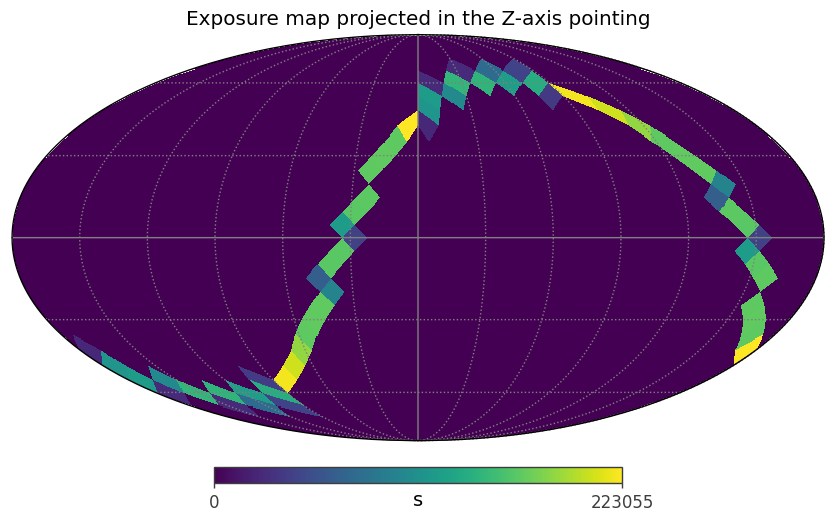

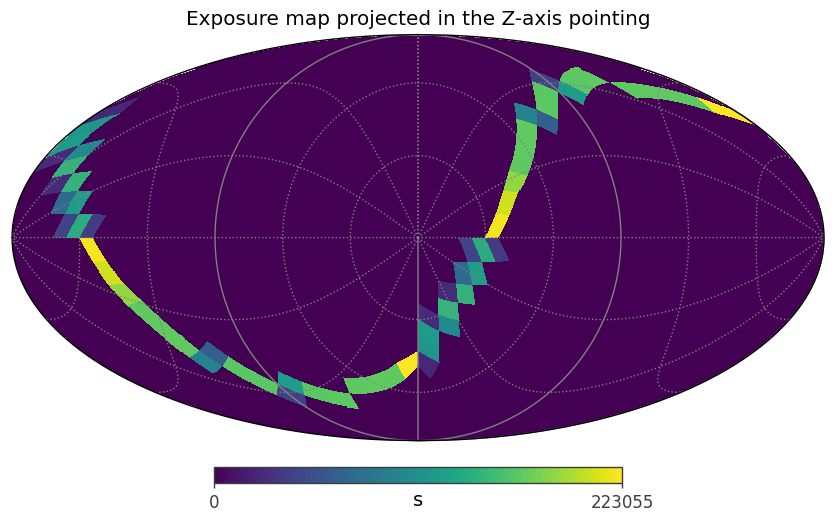

In [12]:
hp.mollview(map_pointing_zx.project('z').contents, rot=(0,0), unit = u.s, title = "Exposure map projected in the Z-axis pointing")
hp.graticule(color='gray', dpar = 30)
plt.show()

hp.mollview(map_pointing_zx.project('z').contents, rot=(0,90), unit = u.s, title = "Exposure map projected in the Z-axis pointing")
hp.graticule(color='gray', dpar = 30)
plt.show()

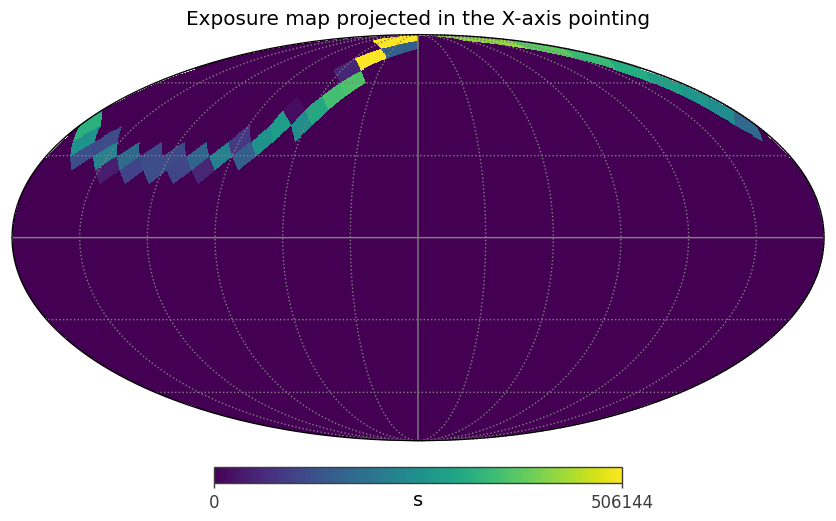

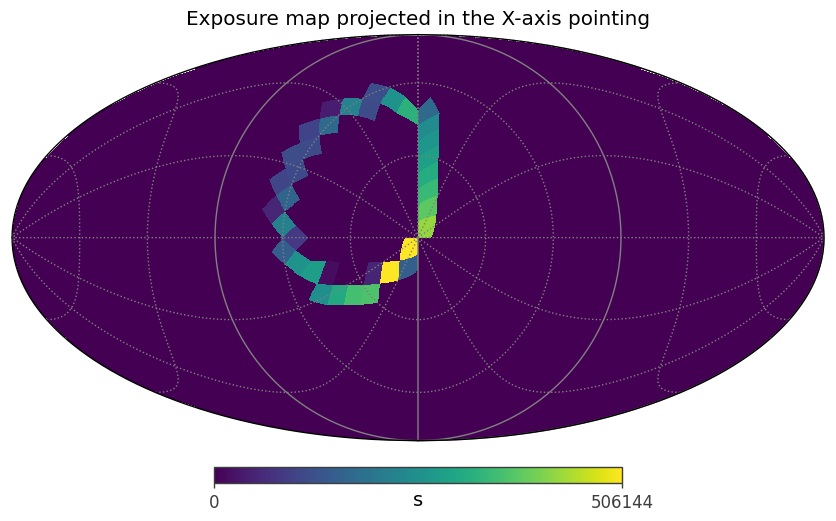

In [13]:
hp.mollview(map_pointing_zx.project('x').contents, rot=(0,0), unit = u.s, title = "Exposure map projected in the X-axis pointing")
hp.graticule(color='gray', dpar = 30)
plt.show()

hp.mollview(map_pointing_zx.project('x').contents, rot=(0,90), unit = u.s, title = "Exposure map projected in the X-axis pointing")
hp.graticule(color='gray', dpar = 30)
plt.show()

# 2. Calculate the coordinate conversion matrix


CoordsysConversionMatrix.spacecraft_attitude_binning_ccm can produce the coordinate conversion matrix for the spacecraft attitude binning.

In this calculation, the dwell time map is calculated for each model pixel and each scatt_binning_index.

If use_averaged_pointing is True, first the averaged Z- and X-pointings are calculated (the average of zpointing or xpointing in the exposure table), and then the dwell time map is calculated once for ach model pixel and each scatt_binning_index.

If use_averaged_pointing is False, the dwell time map is calculated for each attitude in zpointing and xpointing in the exposure table, and then the calculated dwell time maps are summed up. 

In the former case, the computation is fast but may lose the angular resolution. In the latter case, the conversion matrix is more accurate but it takes a long time to calculate it.

In [14]:
%%time

coordsys_conv_matrix = CoordsysConversionMatrix.spacecraft_attitude_binning_ccm(full_detector_response, exposure_table, use_averaged_pointing = True)

  0%|          | 0/768 [00:00<?, ?it/s]

CPU times: user 2min 15s, sys: 2.97 s, total: 2min 18s
Wall time: 2min 16s


You can save CoordsysConversionMatrix as a hdf5 file.

In [15]:
coordsys_conv_matrix.write("ccm.hdf5", overwrite = True)

You can also read the saved file.

In [16]:
coordsys_conv_matrix = CoordsysConversionMatrix.open("ccm.hdf5")

# 3. produce the binned data

Using the exposure table, we can produce the binned data.

In [11]:
def get_binned_data_scatt(unbinned_event, exposure_table, psichi_binning = 'local', sparse = False):
    exposure_dict = {row['healpix_index']: row['scatt_binning_index'] for _, row in exposure_table.iterrows()}
        
    # from BinnedData.py
 
    # Get energy bins:
    energy_bin_edges = np.array(unbinned_event.energy_bins)
    
    # Get phi bins:
    number_phi_bins = int(180./unbinned_event.phi_pix_size)
    phi_bin_edges = np.linspace(0,180,number_phi_bins+1)
    
    # Define psichi axis and data for binning:
    if psichi_binning == 'galactic':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = 'galactic', label='PsiChi')
        coords = SkyCoord(l=unbinned_event.cosi_dataset['Chi galactic']*u.deg, b=unbinned_event.cosi_dataset['Psi galactic']*u.deg, frame = 'galactic')
    if psichi_binning == 'local':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = SpacecraftFrame(), label='PsiChi')
        coords = SkyCoord(lon=unbinned_event.cosi_dataset['Chi local']*u.rad, lat=((np.pi/2.0) - unbinned_event.cosi_dataset['Psi local'])*u.rad, frame = SpacecraftFrame())

    # Define scatt axis and data for binning
    n_scatt_bins = len(exposure_table)
    scatt_axis = Axis(np.arange(n_scatt_bins + 1), label='ScAtt')
    
    is_nest = True if exposure_table.scheme == 'nested' else False
    
    nside_scatt = exposure_table.nside
    
    zindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)
    xindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)    
    scatt_data = np.array( [ exposure_dict[(z, x)] + 0.5 if (z,x) in exposure_dict.keys() else -1 for z, x in zip(zindex, xindex)] ) # should this "0.5" be needed?
    
    # Initialize histogram:
    binned_data = Histogram([scatt_axis,
                              Axis(energy_bin_edges*u.keV, label='Em'),
                              Axis(phi_bin_edges*u.deg, label='Phi'),
                              psichi_axis],
                              sparse=sparse)

    # Fill histogram:
    binned_data.fill(scatt_data, unbinned_event.cosi_dataset['Energies']*u.keV, np.rad2deg(unbinned_event.cosi_dataset['Phi'])*u.deg, coords)    
    
    return binned_data

Load the Crab data (without background)

In [12]:
%%time

signal_filepath = path_data + "Data/Sources/crab_3months_unbinned_data.fits.gz"

unbinned_signal = UnBinnedData(input_yaml = "inputs_Crab_DC2.yaml")

unbinned_signal.cosi_dataset = unbinned_signal.get_dict_from_fits(signal_filepath)

binned_signal = get_binned_data_scatt(unbinned_signal, exposure_table, psichi_binning = 'local', sparse = False)

CPU times: user 12.9 s, sys: 636 ms, total: 13.5 s
Wall time: 13.5 s


Load the background data

In [19]:
%%time

bkg_filepath = path_data + "Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz"

unbinned_bkg = UnBinnedData(input_yaml = "inputs_Crab_DC2.yaml")

unbinned_bkg.cosi_dataset = unbinned_bkg.get_dict_from_fits(bkg_filepath)

binned_bkg = get_binned_data_scatt(unbinned_bkg, exposure_table, psichi_binning = 'local', sparse = False)

CPU times: user 1min 30s, sys: 4.21 s, total: 1min 34s
Wall time: 1min 34s


Sum up the signal and background data

In [20]:
binned_event = binned_signal + binned_bkg

Save them

In [21]:
binned_event.write("Crab_scatt_binning_DC2_event.hdf5")
binned_bkg.write("Crab_scatt_binning_DC2_bkg.hdf5")